# Demonstrating the Exact Coverage of the Nonparametric Analysis
---
*An empirical demonstration that the nonparametric analysis achieves exact coverage*

For more background, see the notebook [**Nonparametric Analysis**](../theory/nonparametric-analysis.ipynb) or our paper: [**Show Your Work with Confidence: Confidence Bands for Tuning Curves**](https://arxiv.org/abs/2311.09480).

In [1]:
# imports

import json
import warnings

from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

from experiments import visualization
from opda import nonparametric, utils
import opda.random

# constants

evaluations = {
    "matched": {
        "name": "MultiNLI-m",
    },
    "mismatched": {
        "name": "MultiNLI-mm",
    },
}

models = {
    "deberta-base": {
        "name": "DeBERTa",
        "style": {"linestyle": "-", "color": "#FFB000"},
    },
    "deberta-v3-base": {
        "name": "DeBERTaV3",
        "style": {"linestyle": "--", "color": "#648FFF"},
    },
}

bands = {
    "dkw": {
        "name": "DKW",
        "method": "dkw",
        "style": {"linestyle": "-.", "color": "#FE6100"},
    },
    "ks": {
        "name": "KS",
        "method": "ks",
        "style": {"linestyle": "-", "color": "#FFB000"},
    },
    "ld_equal_tailed": {
        "name": "LD (equal-tailed)",
        "method": "ld_equal_tailed",
        "style": {"linestyle": ":", "color": "#785EF0"},
    },
    "ld_highest_density": {
        "name": "LD (highest density)",
        "method": "ld_highest_density",
        "style": {"linestyle": "--", "color": "#648FFF"},
    },
}

confidences = {
    0.01: {"style": {"marker": "D", "color": "tab:gray"  }},
    0.05: {"style": {"marker": "o", "color": "tab:blue"  }},
    0.10: {"style": {"marker": "P", "color": "tab:orange"}},
    0.25: {"style": {"marker": "X", "color": "tab:green" }},
    0.50: {"style": {"marker": "*", "color": "tab:red"   }},
    0.75: {"style": {"marker": "s", "color": "tab:purple"}},
    0.90: {"style": {"marker": "v", "color": "tab:brown" }},
    0.95: {"style": {"marker": "^", "color": "tab:pink"  }},
    0.99: {"style": {"marker": "p", "color": "tab:cyan"  }},
}


# experimental settings

evaluation = "matched"
model = "deberta-v3-base"
band = "ld_highest_density"

sample_sizes = [6, 20, 34, 48]
n = sample_sizes[-1]  # Later analyses assume n == sample_sizes[-1]

y_min = 0.
y_max = 1.
grid = np.linspace(y_min, y_max, num=100)

bws = [1.0e-1, 7.5e-2, 5e-2, 2.5e-2]
bw = 5e-2

n_trials = 1_024

cdf_confidence = 0.95
coverage_confidence = 0.99


# Configure environment.

generator = np.random.RandomState(0)
opda.random.set_seed(generator)

warnings.filterwarnings("ignore")


# Configure Matplotlib.

plt.style.use("experiments.default")

## Coverage Guarantees for the Nonparametric Analysis

We want distribution-free confidence bands with *exact* simultaneous coverage. This would mean that for any continuous distribution of performance results, the confidence bands contain the entire tuning curve exactly the requested percentage of the time. Our confidence bands do **not** provide this guarantee for the average tuning curve. On the average tuning curve, the confidence bands are conservative, in part because we cannot bound the tails of the distribution in a nonparametric way. However, the guarantee *does* hold for the median tuning curve. While one can prove this fact, we'll demonstrate it empircally as well.

For these experiments, we'll use data from fine-tuning DeBERTa and DeBERTaV3 on MultiNLI. For details on the models, dataset, or hyperparameter search space, see the notebook: [Evaluating DeBERTaV3 with the Nonparametric Analysis](./evaluating-debertav3-with-the-nonparametric-analysis.ipynb).

In [2]:
# load the data
model_to_evaluation_to_ys = {}
for model_ in models:
    for evaluation_ in evaluations:
        ys = []
        with open(f"../../data/deberta/{model_}_tuning.results.jsonl") as f_in:
            for ln in f_in:
                ex = json.loads(ln)
                ys.append(max(
                    score
                    for _, score in ex["learning_curves"][evaluation_]
                ))
        if model_ not in model_to_evaluation_to_ys:
            model_to_evaluation_to_ys[model_] = {}
        model_to_evaluation_to_ys[model_][evaluation_] = np.array(ys)

total_samples = 1_024
for model_ in models:
    for evaluation_ in evaluations:
        if len(model_to_evaluation_to_ys[model_][evaluation_]) != total_samples:
            raise RuntimeError(
                "The experiment data does not contain the correct"
                " number of examples.",
            )

## Simulating Random Search

In order to measure the coverage, we need to know the ground truth tuning curve. Thus, our approach will be to create a simulation that closely approximates running random search on DeBERTa and DeBERTaV3. To create the simulation, first we take the 1,024 search iterations run on each. Next, we'll use [kernel density estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation) to approximate the continuous performance distributions resulting from random seach. Finally, we'll take these continuous distributions as the ground truth and simulate constructing the confidence bands many times in order to estimate their coverage.

Because of the large sample sizes we use in the KDE, our simulations will closely approximate the underlying distributions' CDFs. We must use KDE rather than bootstrap resampling (i.e., sampling from the empirical CDF) because our coverage guarantee only holds when the underlying distribution is continuous, thus we must remove the discretization effects from having a finite sample.

### Assessing the CDF Fit

Before constructing the simulation, let's check that the sample size is sufficiently large to obtain a tight fit to the underlying distribution.

First, we can visualize what the empirical distributions look like:

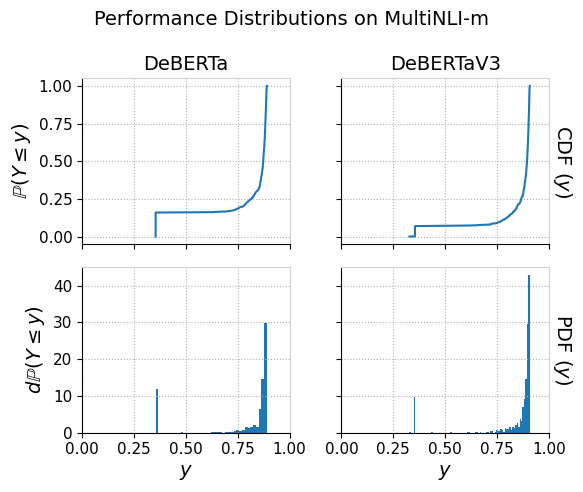

In [3]:
# Plot the performance distributions.
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey="row",
    figsize=(6, 5),
)
for j, model_ in enumerate(models):
    visualization.plot_distribution(
        model_to_evaluation_to_ys[model_][evaluation],
        "y",
        axes=axes[:, j],
    )

# Format the plots.

# Collect titles in order to move them to the right side of the figure.
row_titles = [set() for _ in range(2)]
for i in range(2):
    for j, _ in enumerate(models):
        row_titles[i].add(axes[i, j].get_title())

for i, titles in enumerate(row_titles):
    if len(titles) != 1:
        raise RuntimeError(
            "Found multiple titles for the row.",
        )
    title = next(iter(titles))

    for j in range(1, len(models)):
        axes[i, j].set_ylabel(None)

    axes[i, -1].yaxis.set_label_position("right")
    axes[i, -1].set_ylabel(title, labelpad=18, rotation=270)

for j, model_ in enumerate(models):
    for i in range(1):
        axes[i, j].set_xlabel(None)

    for i in range(2):
        axes[i, j].set_title(None)

    axes[0, j].set_title(models[model_]["name"])

for i in range(len(models)):
    for j in range(2):
        axes[i, j].set_xlim(y_min, y_max)
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

fig.suptitle(
    f'Performance Distributions on {evaluations[evaluation]["name"]}',
)

fig.tight_layout()

plt.show()

Next, let's check how closely the empirical CDF approximates the true CDF. We can visualize the fit using our CDF confidence bands:

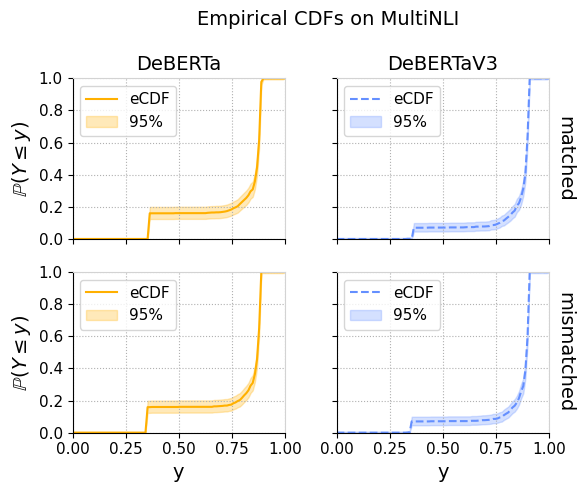

In [4]:
# Plot the CDFs with confidence bands.
fig, axes = plt.subplots(
    nrows=len(evaluations),
    ncols=len(models),
    sharex=True,
    sharey=True,
    figsize=(6, 5),
)
for i, evaluation_ in enumerate(evaluations):
    for j, model_ in enumerate(models):
        lower_cdf, point_cdf, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                model_to_evaluation_to_ys[model_][evaluation_],
                confidence=cdf_confidence,
                a=y_min,
                b=y_max,
                method=band,
            )

        # Plot the confidence bands.
        axes[i, j].plot(
            grid,
            point_cdf.cdf(grid),
            label="eCDF",
            **models[model_]["style"],
        )
        axes[i, j].fill_between(
            grid,
            upper_cdf.cdf(grid),
            lower_cdf.cdf(grid),
            alpha=0.275,
            label=f"{cdf_confidence * 100:.0f}%",
            color=models[model_]["style"]["color"],
        )

# Format the plots.
for j, model_ in enumerate(models):
    axes[1, j].set_xlabel("y")
    axes[0, j].set_title(models[model_]["name"])

for i, evaluation_ in enumerate(evaluations):
    axes[i, 0].set_ylabel(r"$\mathbb{P}(Y \leq y)$")
    axes[i, -1].yaxis.set_label_position("right")
    axes[i, -1].set_ylabel(evaluation_, labelpad=18, rotation=270)

for i in range(len(evaluations)):
    for j in range(len(models)):
        axes[i, j].set_xlim(y_min, y_max)
        axes[i, j].set_ylim(0., 1.)
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")
        axes[i, j].legend(loc="upper left")

fig.suptitle(
    "Empirical CDFs on MultiNLI",
    x=0.56,
)

fig.tight_layout()

plt.show()

Due to our large sample size of 1,024 search iterations, the confidence bands are extremely narrow and thus the empirical CDF approximates the true CDF very well for all models and evaluation test sets.

### Choosing the KDE Bandwidth

The most important hyperparameter in KDE is the bandwidth. Intuitively, we'd like our simulation to behave like resampling except with the discretization effects removed. Thus, we want a relatively small bandwidth that preserves the distribution's shape. Cross-validation tends to encourage oversmoothing in order to cover unseen points with high likelihood. Instead, we will select the bandwidth visually.

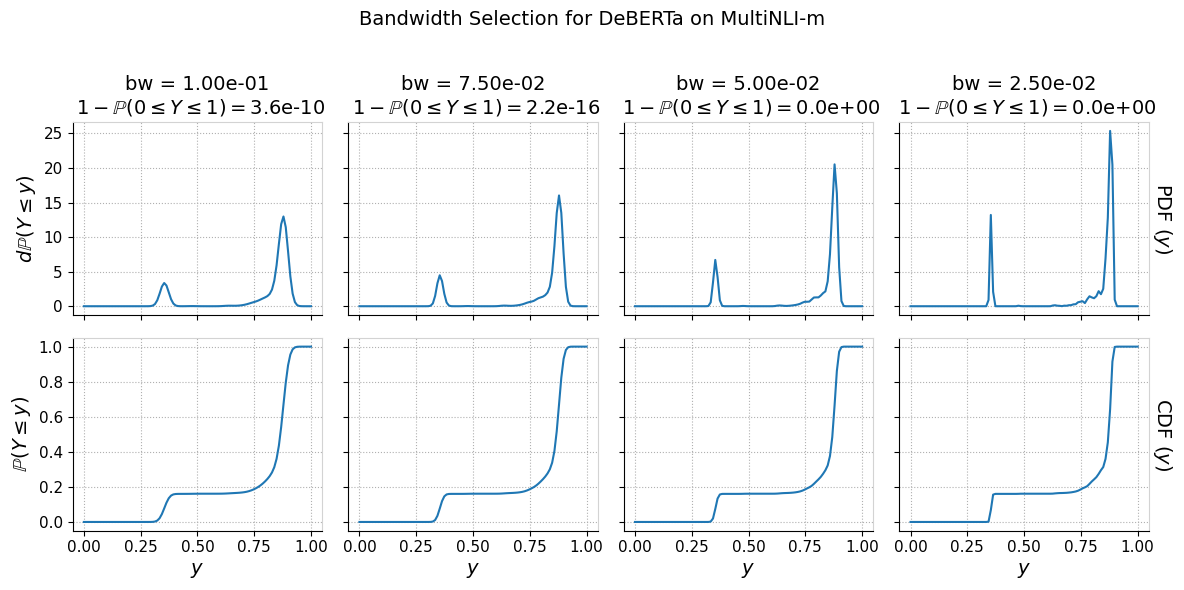

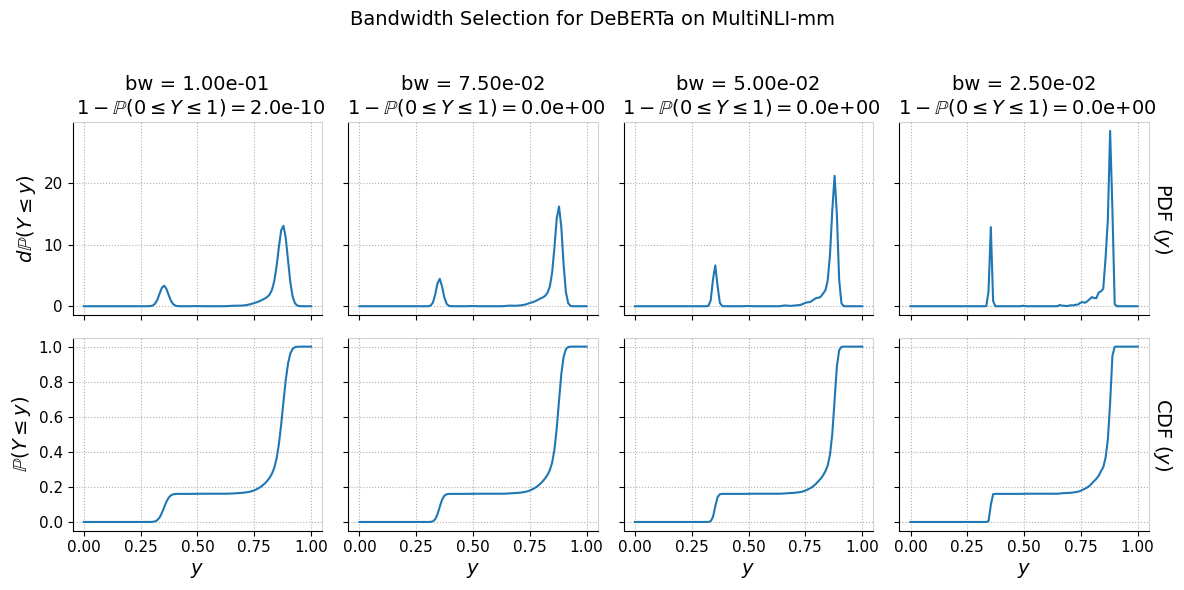

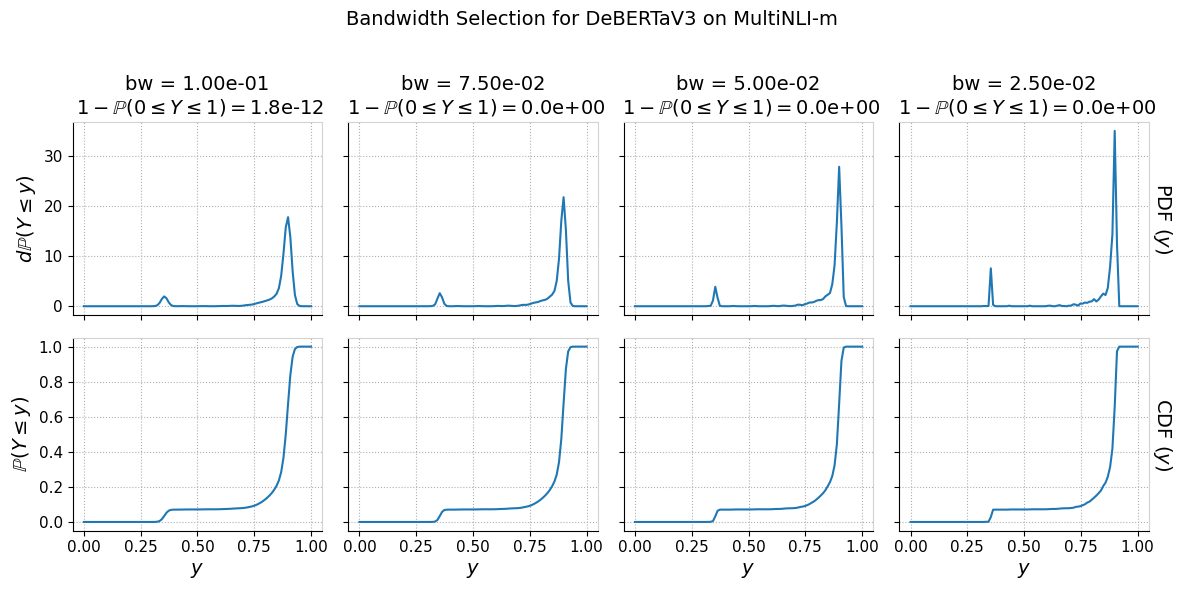

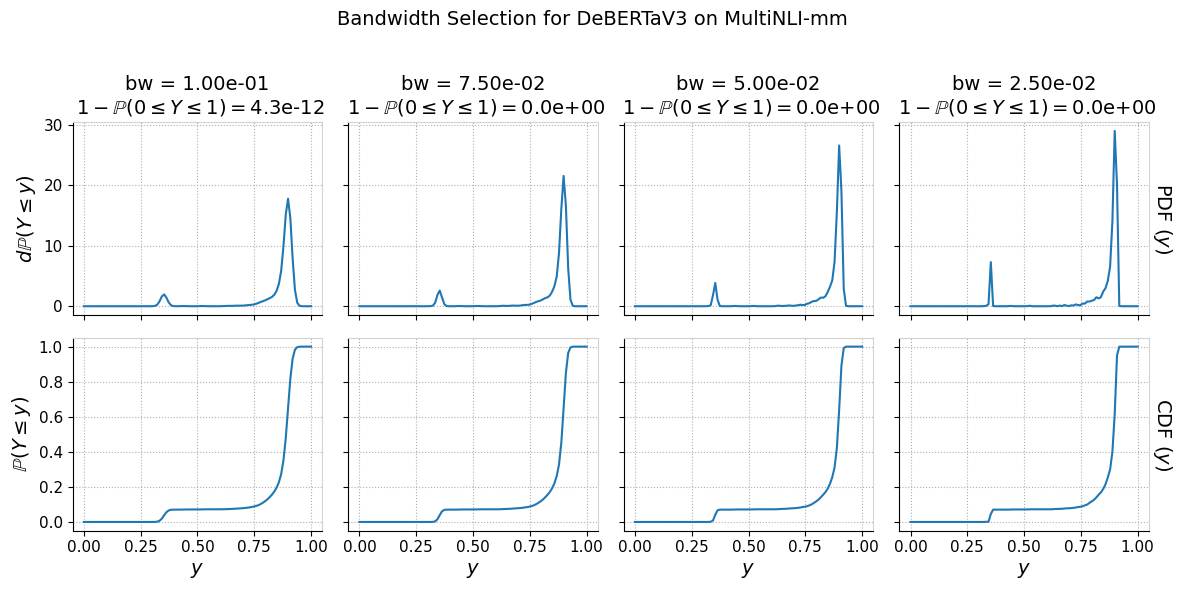

In [5]:
# Plot the distribution for various bandwidths.
for model_ in models:
    for evaluation_ in evaluations:
        fig, axes = plt.subplots(
            nrows=len(models),
            ncols=len(bws),
            sharex=True,
            sharey="row",
            figsize=(12, 6),
        )
        total_probabilities = []
        for j, bw_ in enumerate(bws):
            kde = stats.gaussian_kde(
                model_to_evaluation_to_ys[model_][evaluation_],
                bw_method=bw_,
            )

            total_probabilities.append(kde.integrate_box_1d(0, 1))

            axes[0, j].plot(
                grid,
                kde.pdf(grid),
            )
            axes[1, j].plot(
                grid,
                [kde.integrate_box_1d(y_min, y) for y in grid],
            )

        # Format the plots.
        for j, (bw_, total_probability) in enumerate(
            zip(bws, total_probabilities),
        ):
            axes[1, j].set_xlabel("$y$")
            axes[0, j].set_title(
                 f"bw = {bw_:.2e}\n"
                rf" $1 - \mathbb{{P}}(0\leq Y\leq 1)=${1-total_probability:.1e}",
            )

        for i, kind in enumerate(["PDF ($y$)", "CDF ($y$)"]):
            axes[i, -1].yaxis.set_label_position("right")
            axes[i, -1].set_ylabel(kind, labelpad=18, rotation=270)

        axes[0, 0].set_ylabel(r"$d\mathbb{P}(Y \leq y)$")
        axes[1, 0].set_ylabel(r"$\mathbb{P}(Y \leq y)$")

        for i in range(2):
            for j in range(len(bws)):
                axes[i, j].spines["right"].set_color("lightgrey")
                axes[i, j].spines["top"].set_color("lightgrey")

        fig.suptitle(
            f'Bandwidth Selection for {models[model_]["name"]}'
            f' on {evaluations[evaluation_]["name"]}\n',
        )

        fig.tight_layout()

        plt.show()

From the above plots, a bandwidth of 0.05 seem to strike a reasonable trade-off for all model evaluation pairs.

One challenge for KDE is estimating the distribution near the boundary. Kernels near the boundary tend to spill probability mass over it. Restricting to inside the bounds and renormalizing the distribution creates bias that makes the density estimates at the boundary inconsistent. There are various ways to correct this boundary bias. In the above plots, we see that almost all of the probability mass from the KDE estimate stays within the bounds&mdash;to the point that our numerical calculations round the mass outside the boundary to zero for smaller bandwidths (0.05 and 0.025). We could attempt to correct for the unknown ends of the support; however, such corrections for unknown bounds are more complicated and the boundary bias in this case affects only the density estimate and not so much the sampling or CDF. Thus, a boundary correction is unnecessary for this experiment.

## Computing the Confidence Bands' Simultaneous Coverage

Now that we have our simulation, we can empirically assess the confidence bands' coverage.

First, let's evaluate the coverage for the *CDF* confidence bands. Using our KDE, we can sample from the simulated performance distribution, construct the confidence bands, and then measure their coverage empirically.

In [6]:
# Compute the empirical coverage for each model/evaluation pair.
model_to_evaluation_to_coverage = {
    model_: {
        evaluation_: [[], [], []]
        for evaluation_ in evaluations
    }
    for model_ in models
}
for model_ in models:
    for evaluation_ in evaluations:
        # Construct the KDE simulation for the model/evaluation.
        kde = stats.gaussian_kde(
            model_to_evaluation_to_ys[model_][evaluation_],
            bw_method=bw,
        )
        for confidence_ in confidences:
            n_covered = 0
            for _ in range(n_trials):
                # Sample from the simulation.
                ys = kde.resample(n, seed=generator).squeeze()

                # Construct the confidence bands.
                lower_cdf, _, upper_cdf =\
                    nonparametric.EmpiricalDistribution.confidence_bands(
                        ys,
                        confidence=confidence_,
                        a=y_min,
                        b=y_max,
                        method=band,
                    )

                # Test if the confidence bands cover the true CDF.
                covered = True
                # NOTE: We only need to test for violations at and just
                # before the order statistics, since the confidence
                # bands are step functions.
                for test_point in [
                    y_min,
                    *(ys - 1e-15),
                    *ys,
                    y_max,
                ]:
                    true_cdf_value = kde.integrate_box_1d(y_min, test_point)
                    covered = covered and (
                        lower_cdf.cdf(test_point) <= true_cdf_value
                    ) & (
                        true_cdf_value <= upper_cdf.cdf(test_point)
                    )
                    if not covered:
                        break

                n_covered += covered

            coverage = n_covered / n_trials
            lo, hi = utils.binomial_confidence_interval(
                n_successes=n_covered,
                n_total=n_trials,
                confidence=coverage_confidence,
            )

            model_to_evaluation_to_coverage\
                [model_][evaluation_][0].append(lo)
            model_to_evaluation_to_coverage\
                [model_][evaluation_][1].append(coverage)
            model_to_evaluation_to_coverage\
                [model_][evaluation_][2].append(hi)

for model_ in models:
    for evaluation_ in evaluations:
        model_to_evaluation_to_coverage[model_][evaluation_] = tuple(
            map(np.array, model_to_evaluation_to_coverage[model_][evaluation_]),
        )

Now that we have the empirical coverages, we can plot them against the nominal confidence levels:

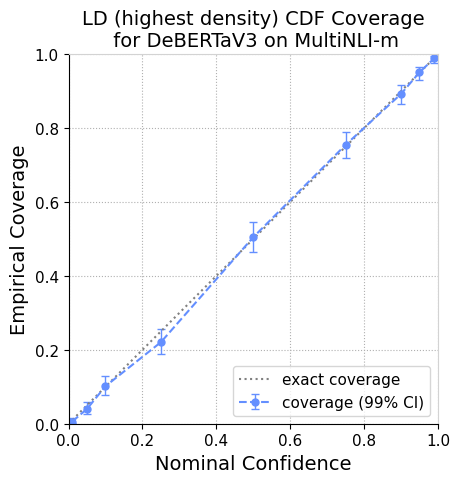

In [7]:
coverage_los, coverages, coverage_his =\
    model_to_evaluation_to_coverage[model][evaluation]

# Plot the nominal vs. empirical coverage of the CDF bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.errorbar(
    confidences.keys(),
    coverages,
    yerr=np.abs(coverages - np.stack([coverage_los, coverage_his])),
    marker="o",
    markersize=5,
    elinewidth=1,
    capsize=3,
    capthick=1,
    label=f"coverage ({100*coverage_confidence:.0f}% CI)",
    **models[model]["style"],
)
ax.plot(
    [0, 1],
    [0, 1],
    color="grey",
    linestyle=":",
    label="exact coverage",
)

# Format the plot.
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal")
ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")
ax.legend(loc="lower right")
ax.set_xlabel("Nominal Confidence")
ax.set_ylabel("Empirical Coverage")
ax.set_title(
    f'{bands[band]["name"]} CDF Coverage\n'
    f' for {models[model]["name"]} on {evaluations[evaluation]["name"]}',
)

fig.tight_layout()

plt.show()

As predicted by the theory, the CDF confidence bands have exact coverage in practice.

We can also produce the same plot for all models and evaluations:

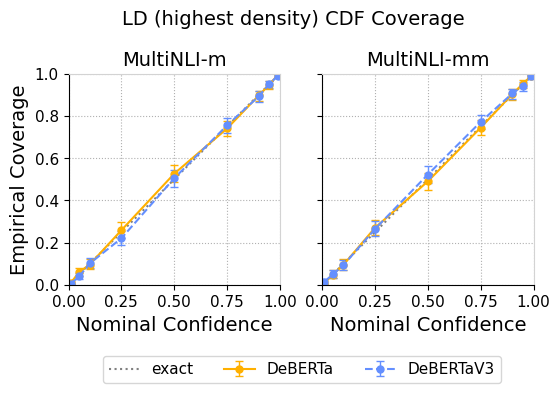

In [8]:
# Plot the nominal vs. empirical coverage of the CDF bands for all
# model/evaluation pairs.
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)
for i, evaluation_ in enumerate(evaluations):
    for model_ in models:
        coverage_los, coverages, coverage_his =\
            model_to_evaluation_to_coverage[model_][evaluation_]

        axes[i].errorbar(
            confidences.keys(),
            coverages,
            yerr=np.abs(coverages - np.stack([coverage_los, coverage_his])),
            marker="o",
            markersize=5,
            elinewidth=1,
            capsize=3,
            capthick=1,
            label=models[model_]["name"],
            **models[model_]["style"],
        )

    axes[i].plot(
        [0, 1],
        [0, 1],
        color="grey",
        linestyle=":",
        label="exact",
    )

# Format the plot.
for i, evaluation_ in enumerate(evaluations):
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    axes[i].set_aspect("equal")
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")
    axes[i].set_xlabel("Nominal Confidence")
    axes[i].set_title(evaluations[evaluation_]["name"])

axes[0].set_ylabel("Empirical Coverage")
axes[0].legend(
    loc="lower left",
    bbox_to_anchor=(0.125, -0.5),
    ncol=len(models) + 1,
)

fig.suptitle(f'{bands[band]["name"]} CDF Coverage')

plt.show()

Again, in line with the theory, we observe exact coverage for all models and evaluation test sets.

Now, let's evaluate the coverage for the *tuning curve* confidence bands. Again, we'll sample from the simulated performance distribution, construct the confidence bands, and measure their coverage empirically.

In [9]:
# Compute the empirical coverage for each model/evaluation pair.
model_to_evaluation_to_coverage = {
    model_: {
        evaluation_: [[], [], []]
        for evaluation_ in evaluations
    }
    for model_ in models
}
for model_ in models:
    for evaluation_ in evaluations:
        # Construct the KDE simulation for the model/evaluation.
        kde = stats.gaussian_kde(
            model_to_evaluation_to_ys[model_][evaluation_],
            bw_method=bw,
        )
        for confidence_ in confidences:
            n_covered = 0
            for _ in range(n_trials):
                # Sample from the simulation.
                ys = kde.resample(n, seed=generator).squeeze()

                # Construct the confidence bands.
                lower_cdf, _, upper_cdf =\
                    nonparametric.EmpiricalDistribution.confidence_bands(
                        ys,
                        confidence=confidence_,
                        a=y_min,
                        b=y_max,
                        method=band,
                    )

                # Test if the confidence bands cover the true tuning
                # curve.
                covered = True
                # NOTE: Since the confidence bands are step functions
                # and the tuning curve is monotonic, we only need to
                # test around values of k such that the k'th power of
                # the CDF at an order statistic equals 0.5.
                #
                # Moreover, we don't have to test at points where the
                # lower CDF is 0 or the upper CDF is 1 since these
                # points are always covered if the adjacent points are
                # covered (at those discontinuities the lower/upper
                # band jumps down/up to the support's bounds).
                order_statistics = np.sort(ys)

                # Check for violations of the lower band.
                order_statistic_quantiles = upper_cdf.cdf(order_statistics)
                order_statistic_quantiles = order_statistic_quantiles[
                    order_statistic_quantiles < 1.
                ]
                test_points = (
                    # w^k = 0.5 implies k = log(0.5) / log(w)
                    (
                        np.log(0.5)
                        / np.log(order_statistic_quantiles)
                    )[:, None]
                    + np.array([-1e-8, 1e-8])[None, :]
                ).reshape(-1)
                lower_tuning_curve_points =\
                    upper_cdf.quantile_tuning_curve(test_points)
                for test_point, lower_point in zip(
                    test_points, lower_tuning_curve_points,
                ):
                    if not covered:
                        break

                    covered = covered and (
                        kde.integrate_box_1d(y_min, lower_point)**test_point
                        <= 0.5
                    )

                # Check for violations of the upper band.
                order_statistic_quantiles = lower_cdf.cdf(order_statistics)
                order_statistic_quantiles = order_statistic_quantiles[
                    order_statistic_quantiles > 0.
                ]
                test_points = (
                    (
                        np.log(0.5)
                        / np.log(order_statistic_quantiles)
                    )[:, None]
                    + np.array([-1e-8, 1e-8])[None, :]
                ).reshape(-1)
                upper_tuning_curve_points =\
                    lower_cdf.quantile_tuning_curve(test_points)
                for test_point, upper_point in zip(
                    test_points, upper_tuning_curve_points,
                ):
                    if not covered:
                        break

                    covered = covered and (
                        0.5
                        <= kde.integrate_box_1d(y_min, upper_point)**test_point
                    )

                n_covered += covered

            coverage = n_covered / n_trials
            lo, hi = utils.binomial_confidence_interval(
                n_successes=n_covered,
                n_total=n_trials,
                confidence=coverage_confidence,
            )

            model_to_evaluation_to_coverage\
                [model_][evaluation_][0].append(lo)
            model_to_evaluation_to_coverage\
                [model_][evaluation_][1].append(coverage)
            model_to_evaluation_to_coverage\
                [model_][evaluation_][2].append(hi)

for model_ in models:
    for evaluation_ in evaluations:
        model_to_evaluation_to_coverage[model_][evaluation_] = tuple(
            map(np.array, model_to_evaluation_to_coverage[model_][evaluation_]),
        )

Let's plot the empirical coverage against the nominal confidence levels:

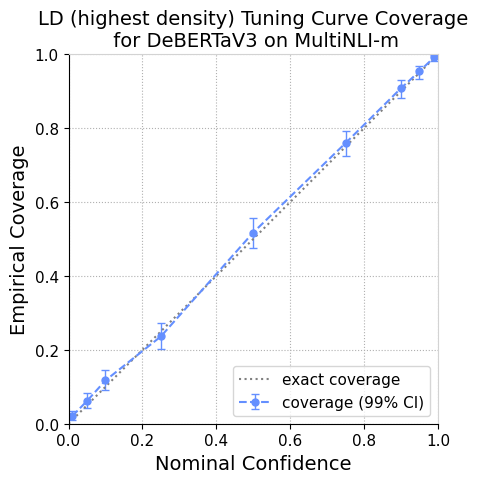

In [10]:
coverage_los, coverages, coverage_his =\
    model_to_evaluation_to_coverage[model][evaluation]

# Plot the nominal vs. empirical coverage of the tuning curve bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.errorbar(
    confidences.keys(),
    coverages,
    yerr=np.abs(coverages - np.stack([coverage_los, coverage_his])),
    marker="o",
    markersize=5,
    elinewidth=1,
    capsize=3,
    capthick=1,
    label=f"coverage ({100*coverage_confidence:.0f}% CI)",
    **models[model]["style"],
)
ax.plot(
    [0, 1],
    [0, 1],
    color="grey",
    linestyle=":",
    label="exact coverage",
)

# Format the plot.
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal")
ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")
ax.legend(loc="lower right")
ax.set_xlabel("Nominal Confidence")
ax.set_ylabel("Empirical Coverage")
ax.set_title(
    f'{bands[band]["name"]} Tuning Curve Coverage\n'
    f' for {models[model]["name"]} on {evaluations[evaluation]["name"]}',
)

fig.tight_layout()

plt.show()

As theory predicts, the median tuning curve confidence bands show exact coverage empirically.

Finally, we'll produce the same plot for all models and evaluations:

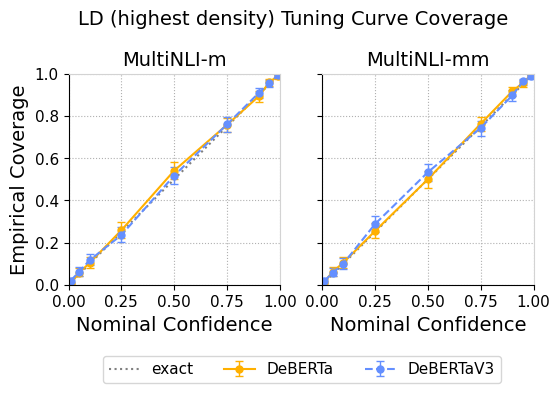

In [11]:
# Plot the nominal vs. empirical coverage of the tuning curve bands for
# all model/evaluation pairs.
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)
for i, evaluation_ in enumerate(evaluations):
    for model_ in models:
        coverage_los, coverages, coverage_his =\
            model_to_evaluation_to_coverage[model_][evaluation_]

        axes[i].errorbar(
            confidences.keys(),
            coverages,
            yerr=np.abs(coverages - np.stack([coverage_los, coverage_his])),
            marker="o",
            markersize=5,
            elinewidth=1,
            capsize=3,
            capthick=1,
            label=models[model_]["name"],
            **models[model_]["style"],
        )

    axes[i].plot(
        [0, 1],
        [0, 1],
        color="grey",
        linestyle=":",
        label="exact",
    )

# Format the plot.
for i, evaluation_ in enumerate(evaluations):
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    axes[i].set_aspect("equal")
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")
    axes[i].set_xlabel("Nominal Confidence")
    axes[i].set_title(evaluations[evaluation_]["name"])

axes[0].set_ylabel("Empirical Coverage")
axes[0].legend(
    loc="lower left",
    bbox_to_anchor=(0.125, -0.5),
    ncol=len(models) + 1,
)

fig.suptitle(f'{bands[band]["name"]} Tuning Curve Coverage')

plt.show()